In [1]:
# Standard library imports
import warnings

# Third-party library imports
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import (
    mean_absolute_error, classification_report, r2_score, 
    accuracy_score, confusion_matrix, roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt

# Suppress warnings
warnings.filterwarnings('ignore')


In [2]:
sp500 = pd.read_csv('S&P Entity Ratings.csv')
audit = pd.read_excel('Critical Audit Mapped.xlsx')
df = sp500.merge(audit, how = 'outer', on='gvkey')
df = df.drop_duplicates(subset='gvkey', keep='last')
df['audit'] = df['TITLE'] + '. ' + df['DESCRIPTION'] + ' ' + df['RESPONSE']
df = df[['ratingsymbol','audit']]
df = df.dropna().reset_index(drop=True)

In [3]:
df

,ratingsymbol,audit
0,BBB+,Regulatory Accounting -- Impact of Rate Regula...
1,BB-,Valuation of the allowance for loan losses. De...
2,AA-,Income taxes - Unrecognized tax benefits. Desc...
3,A-,Estimate of the future policy benefits for ter...
4,BB-,Impairment Assessment - Goodwill In the Energy...
...,...,...
627,BB+,Recoverability of goodwill for the Canadian an...
628,B+,Valuation of Inventories. As described in Note...
629,B-,Goodwill and trade name indefinite-lived intan...
630,B+,Empire wholesale fuel supply contracts. As des...


### Spliting credit ratings (AAA to D) into 3 groups
- Typical rating scales used by major credit rating agencies like Standard & Poor's, Moody's, and Fitch

In [4]:
rating_mapping = {
    'AAA': 2, 'AA+': 2, 'AA': 2, 'AA-': 2,
    'A+': 2, 'A': 2, 'A-': 2,
    'BBB+': 2, 'BBB': 2, 'BBB-': 2, 
    'BB+': 1, 'BB': 1, 'BB-': 1, 
    'B+': 1, 'B': 1, 'B-': 1,
    'CCC+': 0, 'CCC': 0, 'CCC-': 0, 
    'CC': 0, 'C': 0,
    'D': 0,
}

df['ratingsymbol'] = df['ratingsymbol'].map(rating_mapping)

In [5]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['audit'])
y = df[['ratingsymbol']]

# NLP
- (Project) To build a NLP model from scratch (without using pretrained model) to predict credit ratings based on the auditor's opinions
- Data processing
    - Tokenization: break down text into smaller units (words or phrases)
    - Removing stopwords : remove words with little meaning ("the", "is")
    - Lemmatization/Stemming : reduce words to their base or root form
- Feature Extraction: convert text into numerical features
    - Bag of Words: Counts the frequency of words
    - TF-IDF (Term Frequency-Inverse Document Frequency): Weighs the word frequencies by how rare they are in the data
-  Select ML model:
    - XGBoost
        - A type of GBM
        - It is known for high performance in a variety of tasks, including text classification
- Train model
- Performance metrics
    - accuracy, precision, recall, etc

# TF-IDF (Term Frequency-Inverse Document Frequency)
- transform text data into numerical format
- Term Frequency (TF):
    - for each document
        - a more frequency term is more important in understanding the text
        - TF of a term = frequency of the term / total num of terms
- Inverse Document Frequency (IDF)
    - to compare across documents
        - IDF measure how important is a term across documents
        - = logarithmically scaled inverse of the number of documents that contain the term t. This helps to attenuate the effect of terms that occur very frequently across many documents and are thus less informative.
- TF-IDF term = TF term multiple by IDF term
- **High TF-IDF score = a term is frequent in a given document but not across documents, emphasizing its uniqueness and potential importance in the given document**
- Low TD-IDF score: 
    - either:
    - (1) the term appears in many documents across the collection (thus is common and potentially less informative) 
    - or (2) the term is rare in the specific document and in all documents
- sklearn's **TfidfVectorizer**
    - Input all the documents
    - Calc TD-IDF score for each term in all docuemnts
    
# GBM v.s. Random Forest
- Both are ensemble methods that use decision trees
- Bagging (Random Forest): Involves building multiple decision trees independently and combining their predictions through averaging or voting. The individual trees are built from bootstrap samples (random samples with replacement) of the training data.
- Boosting (GBM): Involves building trees sequentially, where each tree attempts to correct the errors of the previous ones. It combines these weak learners to form a strong predictive model. GBMs adjust the weight of each tree according to its performance, and trees are built focusing on errors made in previous stages.
    
# XGBoost
- eXtreme Gradient Boosting
- It is an advanced version of GBM, 
    - Pros:
        - Improved speed and accuracy
        - Regularization: Helps in reducing overfitting.
        - Tree Pruning: Uses depth-first approach, which is more effective than traditional level-wise approach.
            - Depth-First Tree Pruning: grow tree to max depth, then prune tree backward, allowing moel to eliminate unncessary brainches earlier
            - Level-Wise Approach (Traditional GBM): each level of nodes is expanded before moving to the next level, may lead to larger tree than necessary 
        - Built-in Cross-Validation: At each iteration.
       
        
# eval_metric='mlogloss'
- multiclass logloss
- a loss function during training, useful for classification problems with more than two classes
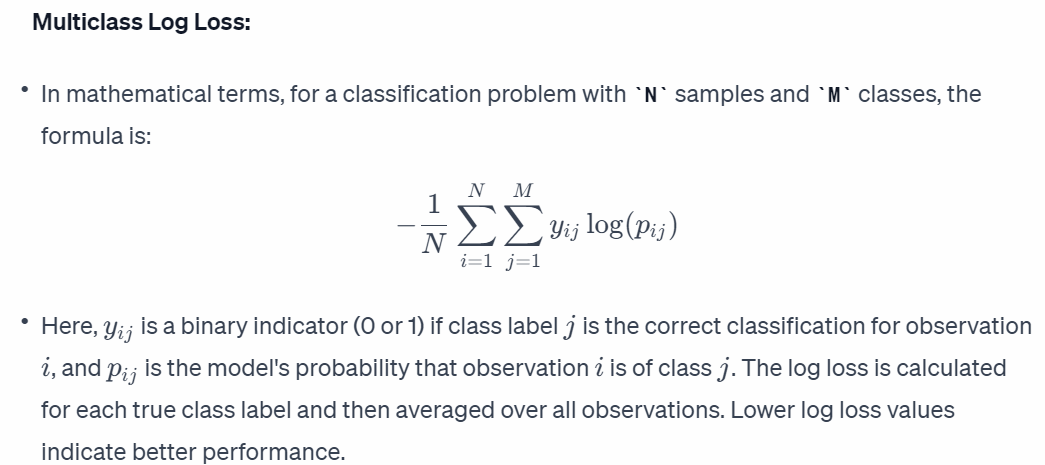

# To reduce class imbalance,  we can manually assign weights to each class
- Adjust weights inversely proportional to class frequencies in the input data. It doesn't make each class 33%, but it assigns a weight to each class so that rarer classes get higher weights and more common classes get lower weights. The goal is to counteract the effect of a class being underrepresented.

In [6]:
# Split the dataset into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

total_samples = len(y_train)
num_classes = len(np.unique(y_train))
weights = {class_label: total_samples / (num_classes * np.count_nonzero(y_train == class_label)) 
           for class_label in np.unique(y_train)}

print("Manually computed class weights:", weights)

# Use these weights for training your model
sample_weights = np.array([weights[cls] for cls in y_train['ratingsymbol']])


Manually computed class weights: {0: 6.4743589743589745, 1: 0.5244029075804777, 2: 1.0654008438818565}


#### Class 0 is the most under-represented in the data set, hence it has the highest weights of 6.47, while class 1 is the most over-represented, hence a low weight of 0.524

# Stratified k-fold cross-validation
- In view of 'imbalanced' data, we use stratified version of k-fold cross-validation, which will maintain the ratio of the classes in each fold as it is in the full dataset

In [7]:
# Stratified K-Folds cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracy_scores = []

for train_index, test_index in kf.split(X, y['ratingsymbol']):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Compute class weights for the current split
    total_samples = len(y_train)
    num_classes = len(np.unique(y_train['ratingsymbol']))
    weights = {class_label: total_samples / (num_classes * np.count_nonzero(y_train['ratingsymbol'] == class_label)) 
               for class_label in np.unique(y_train['ratingsymbol'])}

    # Use these weights for training your model
    sample_weights = np.array([weights[cls] for cls in y_train['ratingsymbol']])

    # Initialize the classifier
    model = XGBClassifier(
        max_depth=15,
        n_estimators=1000,
        learning_rate=0.01,
        gamma=0.01,
        min_child_weight=1,
        subsample=0.5,
        colsample_bytree=0.8,
        seed=42,
    )

    # Train the model
    model.fit(X_train, y_train['ratingsymbol'], sample_weight=sample_weights)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # Calculate accuracy for each fold and append to the accuracy_scores list
    accuracy_scores.append(accuracy_score(y_test['ratingsymbol'], y_pred))

# Calculate average accuracy across all folds
average_accuracy = np.mean(accuracy_scores)
print(f"Average Accuracy: {average_accuracy}")


Average Accuracy: 0.6694692460317461


# Training Model

In [8]:
# Initialize the model
model = XGBClassifier(
    max_depth=15,           # max depth of tree. Higher number increase performance but may overfit
    n_estimators=1000,       # no of gradient boost trees. Higher number increase performance but may overfit
    learning_rate=0.01,     # Higher learning rate --> faster convergence, less time. But lower performance
    gamma=0.01,              # If the splitting of a node doesn't result in a loss reduction greater than gamma, the node won't split.
    min_child_weight=1,     # Higher value to prevent model from learning only from specific data
    subsample=0.5,          # e.g. 0.8 =80% means each tree is trainied on a 80% random subset of rows in training data. 
    colsample_bytree=0.8,    # e.g. 0.8=80% means only 80% of random x varaible is used for training of each tree
    seed= 42,
)

# generally...
# max_depth:
# Low: 1-3 (for simple problems or to prevent overfitting)
# High: 10-15 (for complex problems, but may lead to overfitting)

# n_estimators:
# Low: 50-100 (quick training, but may underfit if too low)
# High: 200-1000 (can capture complex patterns, risk of overfitting)

# learning_rate:
# Low: 0.01-0.05 (slow learning, requires more trees, but often better generalization)
# High: 0.1-0.3 (faster learning, but can overshoot optimal performance)

# gamma:
# Low: 0-0.1 (little to no regularization, more complex models)
# High: 1-5 (strong regularization, conservative models)

# min_child_weight:
# Low: 1 (minimal restriction on leaf nodes)
# High: 10-20 (higher values can prevent overfitting to noise)

# subsample:
# Low: 0.5-0.8 (can help prevent overfitting)
# High: 0.8-1.0 (1.0 means using all data, less randomness)

# colsample_bytree:
# Low: 0.5-0.8 (can help prevent overfitting, adds randomness)
# High: 0.8-1.0 (1.0 means using all features)

# Train the model
model.fit(X_train, y_train['ratingsymbol'], sample_weight=sample_weights)

# Predict on the test set
y_pred = model.predict(X_test)

In [9]:
# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Print the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', conf_matrix)

# Print the classification report for precision, recall, F1-score
class_report = classification_report(y_test, y_pred)
print('Classification Report:\n', class_report)

Accuracy: 0.7936507936507936
Confusion Matrix:
 [[ 0  3  0]
 [ 0 40  1]
 [ 0  9 10]]
Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.77      0.98      0.86        41
           2       0.91      0.53      0.67        19

    accuracy                           0.79        63
   macro avg       0.56      0.50      0.51        63
weighted avg       0.77      0.79      0.76        63



# Multi-classes confusion matrix
Example:
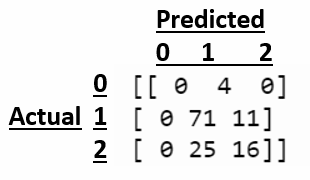
- [0, 0] (Top-left): True negatives for Class 0. The number of times the model correctly predicted that data points were not in Class 0. In this case, it's 0.

##  Analysis of Multi-class Confusion Matrix
- Precision:
    - Indicates how many of the items identified as belonging to a particular class actually belong to that class.
    - For class 1, the precision is 0.77, meaning that 77% of instances predicted as class 1 are actually class 1.
    - For class 2, the precision is high at 0.91, suggesting that when the model predicts class 2, it is correct 91% of the time.
    - Class 0 has a precision of 0.00, indicating the model never correctly identifies any instance of class 0.
- Recall:
    - Measures how many of the items that actually belong to a class were identified correctly.
    - Class 1 has a very high recall of 0.98, which means that the model identifies 98% of all class 1 instances correctly.
    - Class 2 has a lower recall of 0.53, indicating that it identifies only 53% of all actual class 2 instances.
    - Class 0 has a recall of 0.00, indicating that the model fails to identify any actual instances of class 0.
- F1-Score:
    - The F1-score is the harmonic mean of precision and recall, providing a balance between the two.
    - Class 1 has a high F1-score of 0.86, indicating good balance between precision and recall.
    - Class 2's F1-score is 0.67, which is lower, reflecting the lower recall.
    - Class 0's F1-score is 0.00, which is expected given both its precision and recall are 0.
- Support:
    - The support is the number of actual occurrences of the class in the dataset.
    - Class 1 has the highest support with 41 instances, followed by class 2 with 19, and class 0 with only 3 instances.
- Accuracy:
    - This is the ratio of correctly predicted observations to the total observations and is 0.79 for the entire model.
- Macro Avg:
    - The macro average computes the metric independently for each class and then takes the average treating all classes equally. Here, the macro average for precision, recall, and F1-score is relatively low (0.56, 0.50, and 0.51, respectively), indicating disparity in class-wise performance (i.e. mddel is good at predicting one class but poor at predicting another)
- Weighted Avg:
    - The weighted average takes into account the support of each class. This is often more representative of the overall performance when classes are imbalanced.
    - The weighted average scores are higher than the macro averages, reflecting the influence of the more numerous class 1 on the model's overall metrics.
- Conclusion 
    - It is clear that the model performs very well for class 1 but poorly for class 0, likely due to the small number of class 0 instances, making it difficult for the model to learn to identify them. Class 2 is somewhere in between

In [ ]:
# Binarize the output labels for multi-class classification
y_bin = label_binarize(y, classes=[0, 1, 2])
n_classes = y_bin.shape[1]

# Split the dataset (assuming X and y are already defined)
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size=0.2, random_state=42)

# Train the model
model = XGBClassifier()
model.fit(X_train, y_train)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    y_score = model.predict_proba(X_test)
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at these points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
lw = 2
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Area Under the Curve of Receiver Operating Characteristic (AUC ROC)')
plt.legend(loc="lower right")
plt.show()


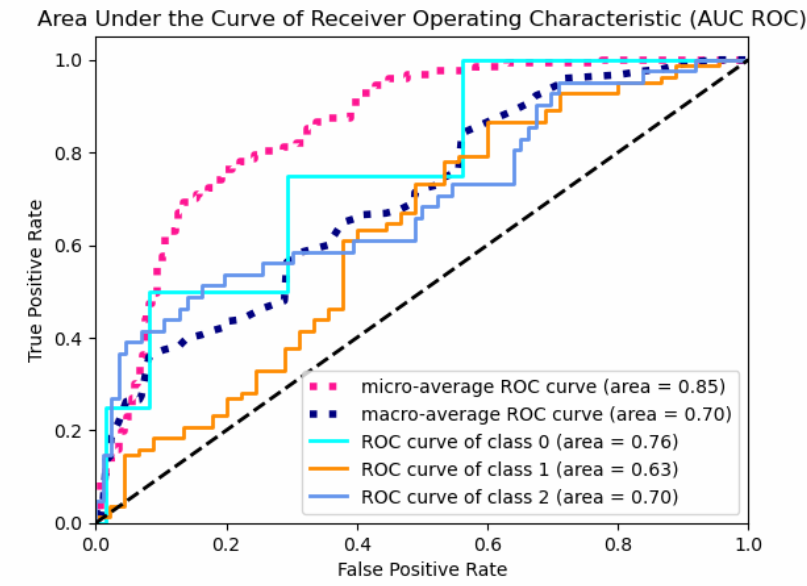

### Analysis of ROC Graph
- Micro vs. Macro Averages:
    - A micro-average AUC of 0.85 indicates that there is an 85% chance that the model will be able to distinguish between a positive and a negative instance regardless of the class. This is a high level of separability and suggests good discriminatory ability.
    - The macro-average ROC curve (solid black line) has an AUC of 0.70, which is also good but suggests there is some variability in performance across the different classes.
    - The micro-average AUC considers the aggregate contributions of all classes to compute the average metric.
    - The macro-average AUC computes the metric independently for each class and then takes the average (hence treating all classes equally).
    - The difference between micro-average and macro-average performance indicates that some classes are predicted with higher confidence than others.

- Class-specific Performance:
    - The AUC for individual classes (class 0, 1, and 2) are 0.76, 0.63, and 0.70 respectively, indicating varying levels of performance for each class. Class 1 has the lowest AUC, suggesting that the model is less effective at distinguishing this class from the others
    
- Interpreting the Curves:
    - The smoothness of the ROC curves can be indicative of the sample size and variability. In this graph, the curves are somewhat "steppy", which can happen if the dataset isn't large or if the decision thresholds are not finely grained.

### Thank you for reading :)